# Quantum computing and materials science: A practical guide to applying quantum annealing to the configurational analysis of materials

This notebook contains the data used in the paper: B.Camino et al. "Quantum computing and materials science: A practical guide to applying quantum annealing to the configurational analysis of materials".

This results in this notebook are reported following the same structure of the publication:
- [The model and results](#model_results)
    - [The Ising and QUBO models](#ising)
    - [Is quantum annealing needed for this problem](#need)
    - [Objectives](#objectives)
        - [Number of bonds](#n_bonds)
        - [Vacancy-free case](#vacancy_free)
    - [Constraints and penalties](#constraints)
        - [Single-vacancy case](#single_vac)
        - [Two and three vacancies](#two_vac)
    - [Coordination](#coordination)

APPENDIX
- [Vacancies in graphene as a graph partitioning problem](#partitioning)
- [Tuning the model parameters](#tuning)
    - [Ratio λ/α](#ratio)
    - [Chain strength](#chain)
    - [Annealing time](#time)
    - [α and λ absolute value](#absolute)
    - [Considerations on the configurations multiplicity](#multiplicity)
    - [Comparing the QA energies to DFT](#dft)



II. The model and results 6
A. Analogies with the “classical” quantum chemical approach 6
B. The Ising and QUBO models 8
C. The vacancies in graphene workflow 8
D. Is quantum annealing needed for this problem? 10
E. Objectives 11 1. Number of bonds 11 2. Vacancy-free case 12
F. Constraints and penalties 12 1. Single-vacancy case 14 2. Two and three vacancies 16
G. Coordination

In [8]:
import sys
import os
import copy
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dwave.embedding.chain_strength import  uniform_torque_compensation
from dimod.binary import BinaryQuadraticModel
from dwave.system import EmbeddingComposite, DWaveSampler

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter

from ase.visualize import view

from CRYSTALpytools.crystal_io import *
from CRYSTALpytools.convert import *

sys.path.insert(1,'../')
from quantum_computing_functions import *
from quantum_computing_postprocessing import *
from paper_functions import *

import dataframe_image as dfi

import warnings
warnings.filterwarnings('ignore')

np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
graphene_supercell.num_sites

18

## Build the graphene supercell
The graphene supercell is built as a pymatgen Structure object

In [2]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
print('There are %s sites in the structure'%graphene_supercell.num_sites)

There are 18 sites in the structure


# <a id='need'>Is quantum annealing needed for this problem</a>

For a fixed number of sites $N_{\textit{sites}}$ and vacancies $N_{\textit{vac}}$, the number of configurations can be calculated by using the binomial factor:
$$
\binom{N_{\textit{sites}}}{N_{\textit{vac}}} = \frac{N_{\textit{sites}}!}
{{N_{\textit{vac}}}
!(N_{\textit{sites}}-N_{\textit{vac}})!}
$$

In [2]:
N_sites = 18
N_vac = 3

In [4]:
binom = np.math.factorial(N_sites)/(np.math.factorial(N_vac)*np.math.factorial(N_sites-N_vac))
print('For %s sites and %s vacancies, there are %s possible configurations.'%(N_sites,N_vac,int(binom)))

For 18 sites and 3 vacancies, there are 816 possible configurations.


# <a id='model_results'>The model and results</a>

# The QUBO model
The full QUBO model used in the paper is:
$$
        \mathbf{U} = \underbrace{
        \alpha \sum_{i}^{N_{sites}}\sum_{j>i}^{N_{sites}} - A_{i,j} x_{i} x_{j}
        }_\text{broken bonds objective}
        +  
        \underbrace{
        \beta \sum_{i}^{N_{sites}}\sum_{j>i}^{N_{sites}} - B_{i,j} x_{i} x_{j}
        }_\text{coordination objective}
        +
        \underbrace{
        \lambda
        \left(
        \sum_{i}^{N_{sites}} \left(1-2N_{C}\right) x_{i} +
        \sum_{i}^{N_{sites}}\sum_{j>i}^{N_{sites}} 2 x_{i} x_{j}
        \right)
        }_\text{constraint} = \\
        \lambda \sum_{i}^{N_{sites}} \left(1-2N_{C}\right) x_{i} +
        \sum_{i}^{N_{sites}}\sum_{j>i}^{N_{sites}} \left(2\lambda - \alpha A_{i,j} - \beta B_{i,j} \right) x_{i} x_{j}
$$

where $N_{sites}$ is the number of sites in the graphene supercell and $N_{C}$ is the number of Carbon atoms. 

$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = \lambda\left(1-2N_{C}\right) & \text{for } i=j \\
        Q_{i,j} = \left(2\lambda - \alpha A_{i,j} - \beta B_{i,j}\right) & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$

In the following, only the parts of the Hamiltonian used in each Section is reported.

# <a id='objectives'>Objectives</a>
At first, only objectives, in this case maximising the number of bonds in the structure are included in the energy model.

# <a id='n_bonds'>Number of bonds</a>

# <a id='vacancy_free'>Vacancy-free case</a>


Hamiltonian:
$$
        \mathbf{U} = \underbrace{
        \alpha \sum_{i}^{N_{sites}}\sum_{j>i}^{N_{sites}} - A_{i,j} x_{i} x_{j}
        }_\text{broken bonds objective} = 
        \sum_{i}^{N_{sites}}\sum_{j>i}^{N_{sites}}  - \alpha A_{i,j}  x_{i} x_{j}
$$

QUBO model:
$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = - \alpha A_{i,j} & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$
where $\alpha$ = 1


### Build the QUBO model

In [12]:
Q = build_qubo_vacancies(graphene_supercell, num_vac=0, coord_obj=False, lambda_1 = 0, beta=0)

### Run the anneal

In [13]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample_qubo(Q, num_reads = 1000, label='Graphene 3x3 0 vacancies')
dataframe = sampleset.to_pandas_dataframeo()

### Load saved dataframe

In [5]:
dataframe = load_json('./data/graphene_C18_bqm_v0_cF_w11_w20_l1_r1000_t0_1663068004.json')[0]
df_0v = make_df_paper(dataframe,num_vacancies=0,symmetrised=True,structure=graphene_supercell,num_runs=1)
# Uncomment to save the picture
#dfi.export(df_0v,'./data/images/df_0v.jpg',dpi=300)
df_0v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.0,-27.0,100.0


In [6]:
# Write the CRYSTAL input files
structure=graphene_supercell
slurm_file_crystal = './data/crystal/slurm_file_crystal.slurm'
input_file = './data/crystal/graphene.d12'
input_name = 'graphene'
directory = './data/crystal/'

write_crystal_files_vacancies(df_0v,structure,input_file,input_name,directory,
                        dimensionality=2,slurm_file_crystal=None, return_slurm = False)

# <a id='constraints'>Constraints and penalties</a>


# <a id='single_vac'>Single-vacancy case</a>


QUBO model:
$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = \lambda\left(1-2N_{C}\right) & \text{for } i=j \\
        Q_{i,j} = \left(2\lambda - \alpha A_{i,j}\right) & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$
where $\alpha$ = 1, $\lambda$ = 2 and $N_{C}$ = 17

### Build the QUBO model

In [15]:
Q = build_qubo_vacancies(graphene_supercell, num_vac=1, coord_obj=False, lambda_1 = 2, beta=0)

### Run the anneal

In [13]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample_qubo(Q, num_reads = 1000, label='Graphene 3x3 1 vacancy')
dataframe = sampleset.to_pandas_dataframeo()

### Load saved dataframe

### All structures

In [7]:
dataframe = load_json('./data/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1663924860.json')[0]
df_1v = make_df_paper(dataframe,num_vacancies=1,symmetrised=False,only_feasible=False,structure=graphene_supercell,num_runs=1)
sort = np.where(df_1v.iloc[:,0:18].to_numpy() == 0)[1]
df_1v = df_1v.iloc[sort,:]
# Uncomment to save the picture
#dfi.export(df_1v,'./data/images/df_1v_symm.jpg',dpi=300)
df_1v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.90,-24.0,4.1
p,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.26,-24.0,2.1
o,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.87,-24.0,2.9
n,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.96,-24.0,5.2
m,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0.29,-24.0,3.8
l,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0.51,-24.0,2.2
k,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,0.30,-24.0,3.7
j,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1.15,-24.0,2.9
i,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,0.00,-24.0,2.2
h,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1.05,-24.0,10.1


In [8]:
dataframe

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000000,-25.0,52
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,0.000000,-24.0,16
2,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,0.000000,-24.0,45
3,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,0.000000,-24.0,22
4,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,0.000000,-24.0,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0.055556,-19.0,1
167,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.055556,-24.0,1
168,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,0.166667,-19.0,1
169,1,1,1,1,1,1,0,1,0,1,...,1,1,0,1,1,1,1,0.000000,-10.0,1


### Symmetry-inequivalent structures only

In [9]:
#dataframe = load_json('./data/paper/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1666191205.json')[0]
dataframe = load_json('./data/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1663924860.json')[0]
df_1v = make_df_paper(dataframe,num_vacancies=1,symmetrised=True,only_feasible=False,structure=graphene_supercell,num_runs=1)
sort = np.where(df_1v.iloc[:,0:18].to_numpy() == 0)[1]
df_1v = df_1v.iloc[sort,:]
# Uncomment to save the picture
#dfi.export(df_1v,'./data/images/df_1v_symm.jpg',dpi=300)
df_1v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.063,-24.0,73.7


# <a id='two_vac'>Two and three vacancies</a>


## Two-vacancy structure
QUBO model:
$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = \lambda\left(1-2N_{C}\right) & \text{for } i=j \\
        Q_{i,j} = \left(2\lambda - \alpha A_{i,j}\right) & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$
where $\alpha$ = 1, $\lambda$ = 2 and $N_{C}$ = 16

### Build the QUBO model

In [16]:
Q = build_qubo_vacancies(graphene_supercell, num_vac=2, coord_obj=False, lambda_1 = 2, beta=0)

### Run the anneal

In [13]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample_qubo(Q, num_reads = 1000, label='Graphene 3x3 2 vacancy')
dataframe = sampleset.to_pandas_dataframeo()

### Load saved dataframe

### All structures

In [10]:
dataframe = load_json('./data/graphene_C18_bqm_v2_cF_w11_w20_l2_r1000_t0_1663860866.json')[0]
df_2v = make_df_paper(dataframe,num_vacancies=2,symmetrised=False,structure=graphene_supercell,num_runs=1)
#Uncomment to save the picture
#dfi.export(df_2v,'./data/images/df_2v_symm.jpg',dpi=300)
df_2v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
22,1,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.56,-22.0,1.0
43,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1.39,-22.0,0.4
110,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,0.56,-22.0,1.0
48,1,1,1,0,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.00,-22.0,0.8
37,1,1,0,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.37,-22.0,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,1,1,1,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0.00,-21.0,0.3
42,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,2.78,-21.0,0.4
41,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0.00,-21.0,0.3
58,1,1,1,1,0,1,0,1,1,1,...,1,1,1,1,1,1,1,0.00,-21.0,0.2


### Symmetry-inequivalent structures only

In [11]:
dataframe = load_json('./data/graphene_C18_bqm_v2_cF_w11_w20_l2_r1000_t0_1663860866.json')[0]
df_2v = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
#Uncomment to save the picture
#dfi.export(df_2v,'./data/images/df_2v_symm.jpg',dpi=300)
df_2v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.942,-22.0,28.9
b,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.561,-21.0,20.8
c,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0.383,-21.0,5.8
d,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.863,-21.0,16.1
e,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0.347,-21.0,3.2


## Three-vacancy structure
QUBO model:
$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = \lambda\left(1-2N_{C}\right) & \text{for } i=j \\
        Q_{i,j} = \left(2\lambda - \alpha A_{i,j}\right) & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$
where $\alpha$ = 1, $\lambda$ = 2 and $N_{C}$ = 15

### Build the QUBO model

In [16]:
Q = build_qubo_vacancies(graphene_supercell, num_vac=3, coord_obj=False, lambda_1 = 2, beta=0)

### Run the anneal

In [13]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample_qubo(Q, num_reads = 1000, label='Graphene 3x3 3 vacancy')
dataframe = sampleset.to_pandas_dataframeo()

### Load saved dataframe

### All structures

In [12]:
dataframe = load_json('./data/graphene_C18_bqm_v3_cF_w11_w20_l2_r1000_t0_1663870143.json')[0]
df_3v = make_df_paper(dataframe,num_vacancies=3,symmetrised=False,structure=graphene_supercell,num_runs=1)
#Uncomment to save the picture
#dfi.export(df_3v,'./data/images/df_3v_symm.jpg',dpi=300)
df_3v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
178,1,1,1,0,1,1,0,1,1,1,...,1,0,1,1,1,1,1,0.00,-20.0,0.1
117,1,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,1,0.00,-20.0,0.3
113,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,0.00,-20.0,0.2
234,1,1,1,1,1,0,0,1,1,1,...,1,0,1,1,1,1,1,0.00,-20.0,0.2
111,1,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.00,-20.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,1,1,0,1,1,1,1,1,1,1,...,1,1,1,0,1,0,1,0.00,-18.0,0.1
173,1,1,1,0,0,1,1,1,1,1,...,1,1,1,1,1,0,1,0.00,-18.0,0.1
174,1,1,1,0,0,1,1,1,1,1,...,1,1,1,1,1,1,0,2.78,-18.0,0.2
136,1,1,0,1,1,0,0,1,1,1,...,1,1,1,1,1,1,1,0.00,-18.0,0.1


### Symmetry-inequivalent structures only

In [13]:
dataframe = load_json('./data/graphene_C18_bqm_v3_cF_w11_w20_l2_r1000_t0_1663870143.json')[0]
df_3v = make_df_paper(dataframe,num_vacancies=3,symmetrised=True,structure=graphene_supercell,num_runs=1)
#Uncomment to save the picture
#dfi.export(df_3v,'./data/images/df_3v_symm.jpg',dpi=300)
df_3v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.040,-20.0,13.9
b,0,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.950,-19.0,11.7
c,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1.571,-19.0,4.6
d,0,1,1,1,1,0,1,1,1,0,...,1,1,1,1,1,1,1,2.157,-19.0,6.7
e,0,1,1,1,1,1,1,0,1,0,...,1,1,1,1,1,1,1,1.145,-19.0,3.4
f,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.527,-18.0,1.1
g,0,0,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1.853,-18.0,1.2
h,0,0,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,2.829,-18.0,5.7
i,0,0,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,3.100,-18.0,5.2
j,0,1,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000,-18.0,0.2


# <a id='coordination'>Coordination</a>

## Two-vacancy structure
QUBO model:
$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = \lambda\left(1-2N_{C}\right) & \text{for } i=j \\
        Q_{i,j} = \left(2\lambda - \alpha A_{i,j} - \beta B_{i,j}\right) & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$
where $\alpha$ = 1, $\lambda$ = 2, $N_{C}$ = 16 and $\beta$ = 0.05

### Build the QUBO model

In [16]:
Q = build_qubo_vacancies(graphene_supercell, num_vac=2, coord_obj=True, lambda_1 = 2, beta=0.05)

### Run the anneal

In [13]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample_qubo(Q, num_reads = 1000, label='Graphene 3x3 2 vacancy coord')
dataframe = sampleset.to_pandas_dataframeo()

### Load saved dataframe

In [14]:
dataframe = load_json('./data/graphene_C18_bqm_v2_cT_w11_w20.05_l2_r1000_t0_1667490895.json')[0]
df_2v_coord = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
#Uncomment to save the picture
#dfi.export(df_2v_coord,'./data/images/df_3v_coord.jpg')
df_2v_coord

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.558,-19.90,21.9
b,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,3.425,-18.90,8.6
c,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0.902,-18.90,3.7
d,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.721,-18.90,13.1
e,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.157,-18.85,27.3


## Three-vacancy structure
QUBO model:
$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = \lambda\left(1-2N_{C}\right) & \text{for } i=j \\
        Q_{i,j} = \left(2\lambda - \alpha A_{i,j} - \beta B_{i,j}\right) & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$
where $\alpha$ = 1, $\lambda$ = 2, $N_{C}$ = 15 and $\beta$ = 0.05

### Build the QUBO model

In [16]:
Q = build_qubo_vacancies(graphene_supercell, num_vac=3, coord_obj=True, lambda_1 = 2, beta=0.05)

### Run the anneal

In [13]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample_qubo(Q, num_reads = 1000, label='Graphene 3x3 2 vacancy')
dataframe = sampleset.to_pandas_dataframeo()

### Load saved dataframe

In [15]:
dataframe = load_json('./data/graphene_C18_bqm_v3_cT_w11_w20.05_l2_r1000_t0_1666361376.json')[0]
df_3v_coord = make_df_paper(dataframe,num_vacancies=3,symmetrised=True,structure=graphene_supercell,num_runs=1)
#Uncomment to save the picture
#dfi.export(df_3v_coord,'./data/images/df_3v_coord.jpg')
df_3v_coord

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,1,0,1,1,1,1,0,1,1,1,...,1,1,1,1,1,0,1,0.557,-18.15,2.0
b,0,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1.389,-18.15,5.2
c,0,1,1,1,1,1,1,0,1,1,...,1,1,1,1,0,1,1,5.486,-17.20,8.2
d,0,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,0,0.926,-17.20,2.4
e,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1.884,-17.15,11.5
f,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,3.806,-17.15,14.6
g,0,1,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1.112,-16.20,0.5
h,0,1,1,1,1,1,1,0,1,1,...,0,1,1,1,1,1,1,0.538,-16.20,3.1
i,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1.324,-16.15,2.1
j,0,1,0,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,0.404,-16.15,5.5


# <a id='partitioning'>Vacancies in graphene as a graph partitioning problem</a>

In [16]:
import networkx as nx
G = nx.Graph()
A = np.triu(build_adjacency_matrix(structure))
for i in range(structure.num_sites):
    G.add_node(i)
for j,i in enumerate(A):
    bond = np.where(i==1)[0]
    if len(bond) >0:
        for k in bond:
            G.add_edge(j,k)

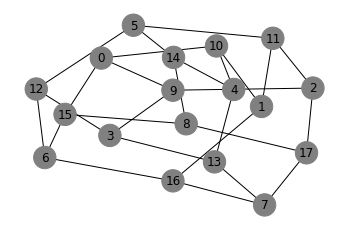

In [17]:
import matplotlib.pyplot as plt

f = plt.figure()
colours = ['grey']*18

#nx.draw_circular(G,node_color=colours, ax=f.add_subplot(111), node_size=500,with_labels=True)
nx.draw(G,node_color=colours, ax=f.add_subplot(111), node_size=500,with_labels=True)

#Uncomment to save the figure
#f.savefig('./data/images/graphene_graph_2v_E.jpg', dpi=300)


# <a id='tuning'>Tuning the model parameters</a>


In this Section of the Notebook, we will tune the following parameters:
- $\lambda$/$\alpha$ ratio
- the chain strength 
- the annealing time

These are evaluate by plotting:
- the % of broken chains
- the % of feasible solutions ($i.e.$, the ones that respect the constraint)
- the % of states ($i.e.$, the ratio of lowest energy and higher energy constraint-resepcting solutions)

# <a id='ratio'>Ratio λ/α</a>

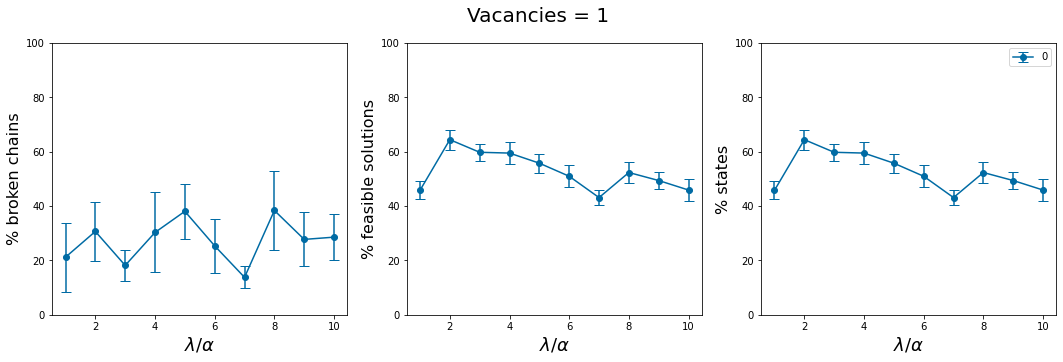

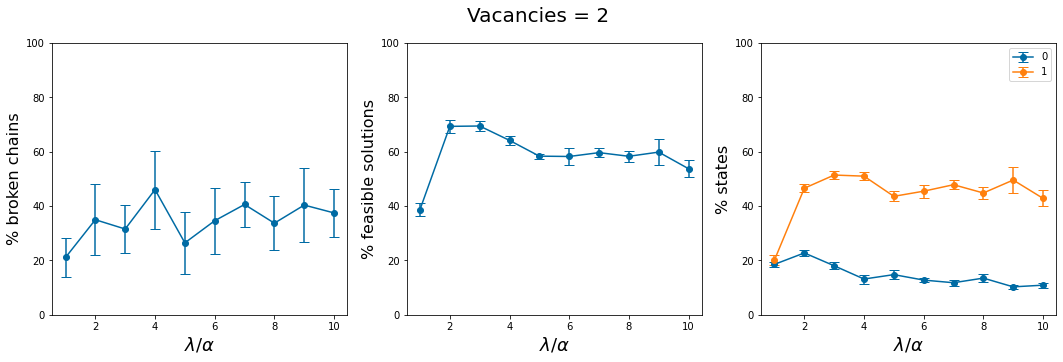

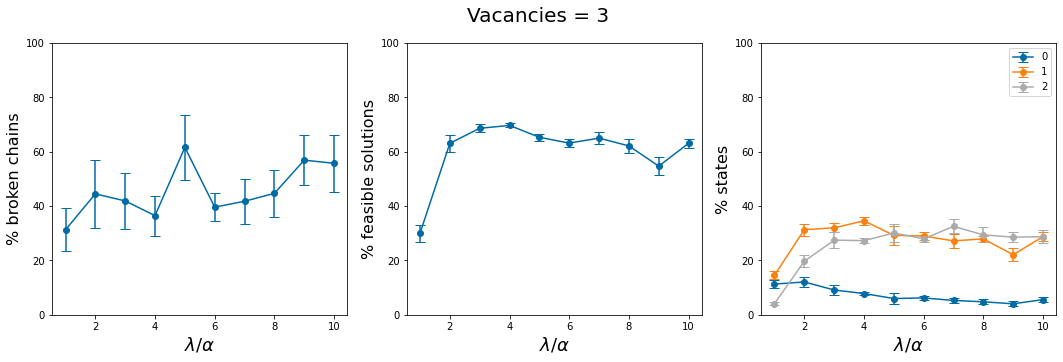

In [18]:
directory_main = './data/convergence/alpha_lambda/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = range(1,11)

for i,vac in enumerate([1,2,3]):    
    directory = os.path.join(directory_main,sub_directory[i])
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    
    ratio_broken_chains = []
    ratio_broken_chains_std = []    
    ratio_feasible = []
    ratio_feasible_std = []    
    energy_distribution = []
    energy_distribution_std = []
    
    for ratio in range(1,11):
        ratio_broken_chains_tmp = []
        ratio_feasible_tmp = []
        energy_distribution_tmp = []
        
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json") and '_l%s_'%ratio in f:
                df, param = load_json(f,return_param = True, return_qubo = False)
                ratio_broken_chains_tmp.append(find_ratio_broken_chains(df)*100)
                ratio_feasible_tmp.append(find_ratio_feasible(df,species=[0,1],concentration=[vac,18-vac])*100)
                energy_distribution_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[1]))
        
                    
        ratio_broken_chains.append(np.average(ratio_broken_chains_tmp))
        ratio_broken_chains_std.append(np.std(ratio_broken_chains_tmp))
        
        ratio_feasible.append(np.average(ratio_feasible_tmp))
        ratio_feasible_std.append(np.std(ratio_feasible_tmp))

        energy_distribution_tmp = np.array(energy_distribution_tmp)/num_reads*100       
        energy_distribution.append(np.average(energy_distribution_tmp,axis=0).tolist())
        energy_distribution_std.append(np.std(energy_distribution_tmp,axis=0).tolist())
        
    axs[0].errorbar(x, ratio_broken_chains, yerr = np.array(ratio_broken_chains_std)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, ratio_feasible, yerr = np.array(ratio_feasible_std)/2,fmt='-o',capsize=5)
    
    labels = [str(x) for x in range(len(energy_distribution[0]))]
    energy_distribution = np.array(energy_distribution)
    energy_distribution_std = np.array(energy_distribution_std)
    for j in range(len(energy_distribution[0])):
        axs[2].errorbar(x, energy_distribution[:,j], yerr = np.array(energy_distribution_std[:,j])/2,
                        label=labels[j], fmt='-o',capsize=5)
    
    axs[0].set_ylabel('% broken chains', fontsize=16)
    axs[1].set_ylabel('% feasible solutions', fontsize=16)
    axs[2].set_ylabel('% states', fontsize=16)
    
    axs[2].legend()
    
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel(r'$\lambda / \alpha$', fontsize=18)
        axs[i].set_ylim([0, 100])
    plt.show()
    fig.savefig('./data/images/alpha_lamdba_graphs_%s.png'%str(vac),dpi=200)

# <a id='chain'>Chain strength</a>

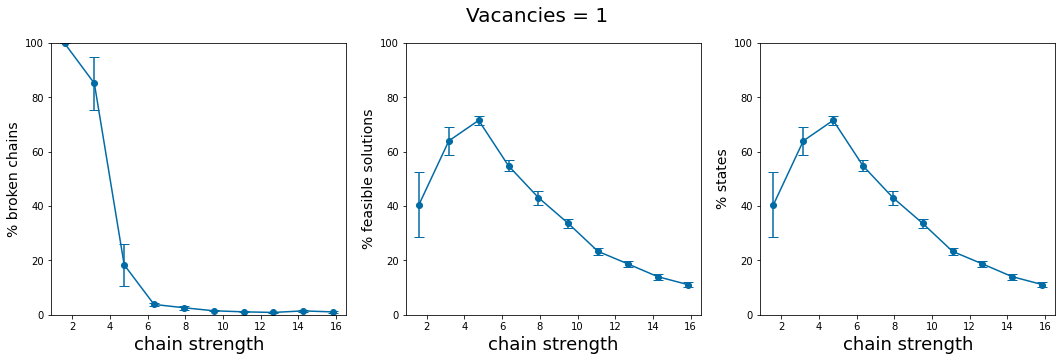

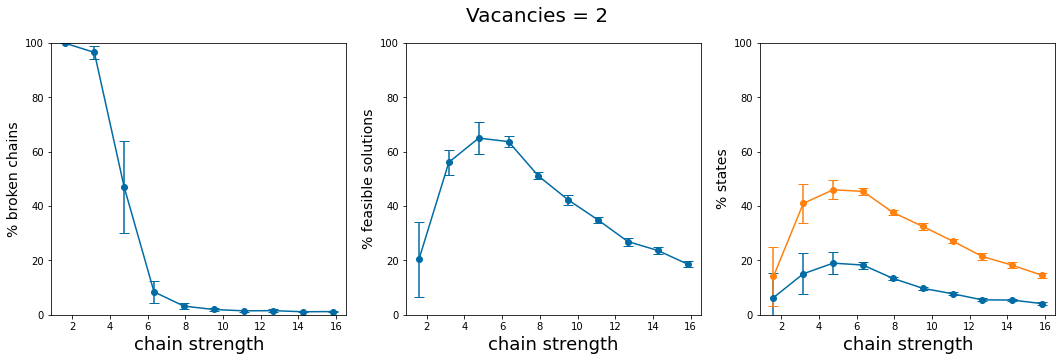

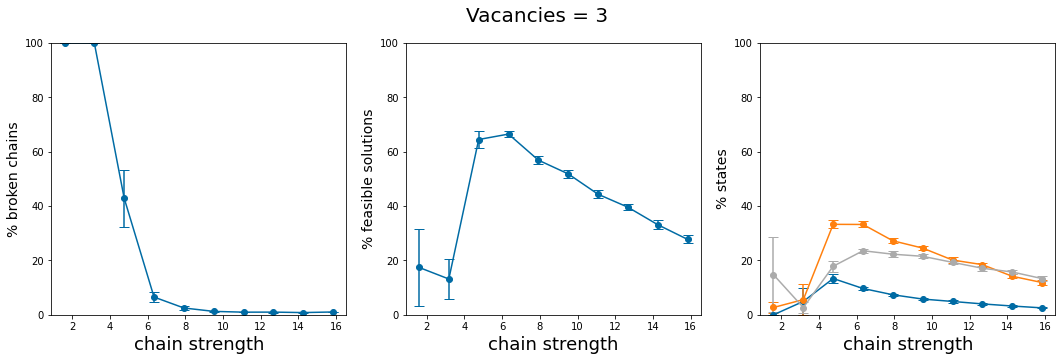

In [19]:
directory_main = './data/convergence/chain_strength/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

#to make sure the lowest chain strength return results
unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]
file = './data/convergence/chain_strength/one_vacancy/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1671525653.json'
Q = load_json(file,return_param = True, return_qubo = True)[2]
Q = Q.reshape((18,18))
bqm = BinaryQuadraticModel.from_qubo(Q)
x = [uniform_torque_compensation(bqm,prefactor=i) for i in np.arange(0.1,1.1,0.1)]

for i,vac in enumerate([1,2,3]):
    directory = os.path.join(directory_main,sub_directory[i])
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    
    ratio_broken_chains = []
    ratio_broken_chains_std = []    
    ratio_feasible = []
    ratio_feasible_std = []    
    energy_distribution = []
    energy_distribution_std = []
    
    for prefactor in np.arange(0.1,1.1,0.1):
        chain_strength = uniform_torque_compensation(bqm,prefactor=prefactor)
        ratio_broken_chains_tmp = []
        ratio_feasible_tmp = []
        energy_distribution_tmp = []
        energy_distribution_2_tmp = []
        
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json"):
                df, param = load_json(f,return_param = True, return_qubo = False)
                if np.round(float(param.loc['chain_strength']),5) == np.round(chain_strength,5):

                    ratio_broken_chains_tmp.append(find_ratio_broken_chains(df)*100)
                    ratio_feasible_tmp.append(find_ratio_feasible(df,species=[0,1],concentration=[vac,18-vac])*100)
            
                    energy_distribution_2_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[0]))
                    energy_distribution_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[1]))
        
        
        for k,energy in enumerate(unique_energies[i]):
            for m,energy_list in enumerate(energy_distribution_2_tmp):
                if energy not in energy_list:
                    energy_distribution_tmp[m].insert(k,0)   
        
        ratio_broken_chains.append(np.average(ratio_broken_chains_tmp))
        ratio_broken_chains_std.append(np.std(ratio_broken_chains_tmp))
        
        ratio_feasible.append(np.average(ratio_feasible_tmp))
        ratio_feasible_std.append(np.std(ratio_feasible_tmp))

        energy_distribution_tmp = np.array(energy_distribution_tmp)/num_reads*100       
        energy_distribution.append(np.average(energy_distribution_tmp,axis=0).tolist())
        energy_distribution_std.append(np.std(energy_distribution_tmp,axis=0).tolist())
    
    
    axs[0].errorbar(x, ratio_broken_chains, yerr = np.array(ratio_broken_chains_std)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, ratio_feasible, yerr = np.array(ratio_feasible_std)/2,fmt='-o',capsize=5)
    
    labels = [str(x) for x in range(len(energy_distribution[0]))]
    energy_distribution = np.array(energy_distribution)
    energy_distribution_std = np.array(energy_distribution_std)
    for j in range(len(energy_distribution[0])):
        axs[2].errorbar(x, energy_distribution[:,j], yerr = np.array(energy_distribution_std[:,j])/2,
                        label=labels[j], fmt='-o',capsize=5)
    
    axs[0].set_ylabel('% broken chains', fontsize=14)
    axs[1].set_ylabel('% feasible solutions', fontsize=14)
    axs[2].set_ylabel('% states', fontsize=14)
      
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel("chain strength", fontsize=18)
        axs[i].set_ylim([0, 100])
    plt.show()
    fig.savefig('./data/images/chain_strength_graphs_%s.png'%str(vac),dpi=200)

# <a id='time'>Annealing time</a>

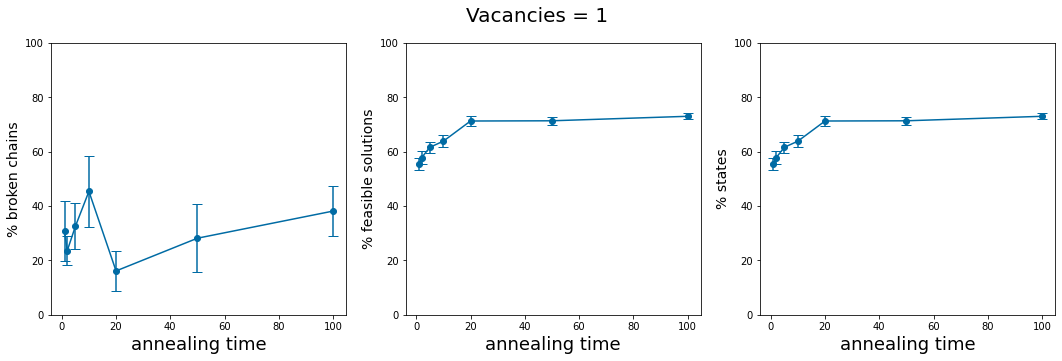

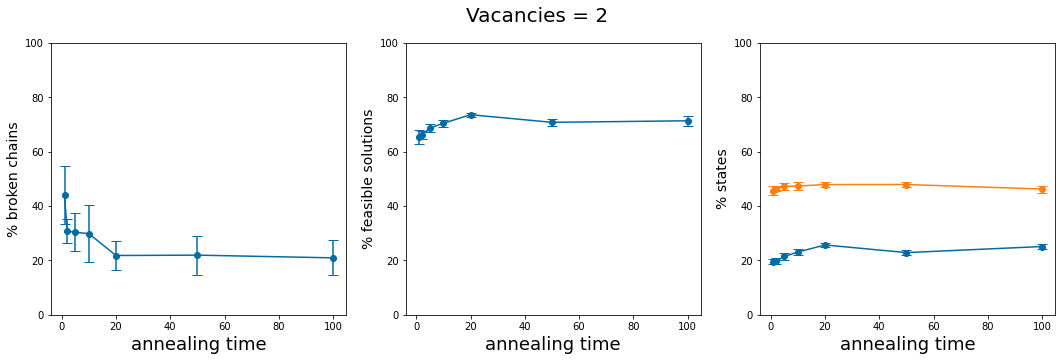

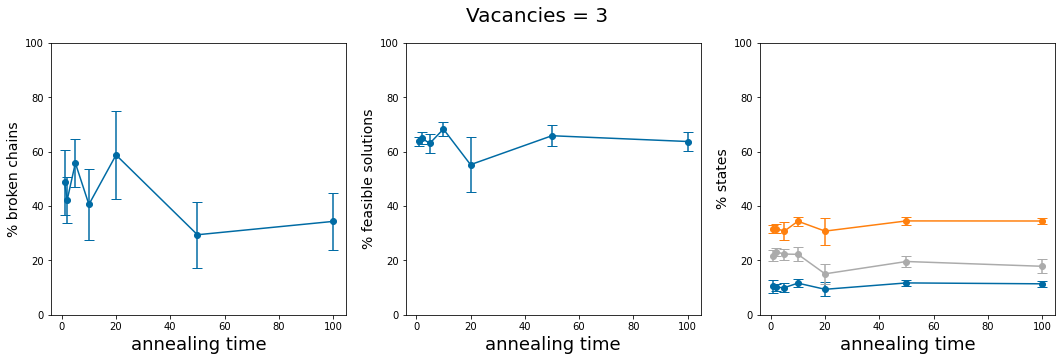

In [20]:
directory_main = './data/convergence/anneal_time/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

#to make sure the lowest chain strength return results
unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]

x = [1,2,5,10,20,50,100]

for i,vac in enumerate([1,2,3]):
    directory = os.path.join(directory_main,sub_directory[i])
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    
    ratio_broken_chains = []
    ratio_broken_chains_std = []    
    ratio_feasible = []
    ratio_feasible_std = []    
    energy_distribution = []
    energy_distribution_std = []
    
    for time in [1,2,5,10,20,50,100]:
        ratio_broken_chains_tmp = []
        ratio_feasible_tmp = []
        energy_distribution_tmp = []
        energy_distribution_2_tmp = []
        
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json"):
                df, param = load_json(f,return_param = True, return_qubo = False)
                #print(param.loc['qpu_anneal_time_per_sample'])
                if int(param.loc['qpu_anneal_time_per_sample']) == int(time):
                    #print(time)
                    #print(chain_strength)
                    ratio_broken_chains_tmp.append(find_ratio_broken_chains(df)*100)
                    ratio_feasible_tmp.append(find_ratio_feasible(df,species=[0,1],concentration=[vac,18-vac])*100)
                    #print(find_energy_distribution(df,only_feasible=True,vacancies=vac)[0])
                    #print(find_energy_distribution(df,only_feasible=True,vacancies=vac)[1])
                    energy_distribution_2_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[0]))
                    energy_distribution_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[1]))
        
        #unique_energy = np.unique(np.array([item for sublist in energy_distribution_2_tmp for item in sublist]))

        for k,energy in enumerate(unique_energies[i]):
            for m,energy_list in enumerate(energy_distribution_2_tmp):
                if energy not in energy_list:
                    energy_distribution_tmp[m].insert(k,0)
        #print(energy_distribution_tmp)    
        
        ratio_broken_chains.append(np.average(ratio_broken_chains_tmp))
        ratio_broken_chains_std.append(np.std(ratio_broken_chains_tmp))
        
        ratio_feasible.append(np.average(ratio_feasible_tmp))
        ratio_feasible_std.append(np.std(ratio_feasible_tmp))
        #print(chain_strength,energy_distribution_tmp)
        energy_distribution_tmp = np.array(energy_distribution_tmp)/num_reads*100       
        energy_distribution.append(np.average(energy_distribution_tmp,axis=0).tolist())
        energy_distribution_std.append(np.std(energy_distribution_tmp,axis=0).tolist())
    
    
    axs[0].errorbar(x, ratio_broken_chains, yerr = np.array(ratio_broken_chains_std)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, ratio_feasible, yerr = np.array(ratio_feasible_std)/2,fmt='-o',capsize=5)
    
    labels = [str(x) for x in range(len(energy_distribution[0]))]
    energy_distribution = np.array(energy_distribution)
    energy_distribution_std = np.array(energy_distribution_std)
    for j in range(len(energy_distribution[0])):
        axs[2].errorbar(x, energy_distribution[:,j], yerr = np.array(energy_distribution_std[:,j])/2,
                        label=labels[j], fmt='-o',capsize=5)
    
    axs[0].set_ylabel('% broken chains', fontsize=14)
    axs[1].set_ylabel('% feasible solutions', fontsize=14)
    axs[2].set_ylabel('% states', fontsize=14)
      
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel("annealing time", fontsize=18)
        axs[i].set_ylim([0, 100])
    plt.show()
    fig.savefig('./data/images/annealing_time_graphs_%s.png'%str(vac),dpi=200)

# <a id='absolute'>α and λ absolute value</a>

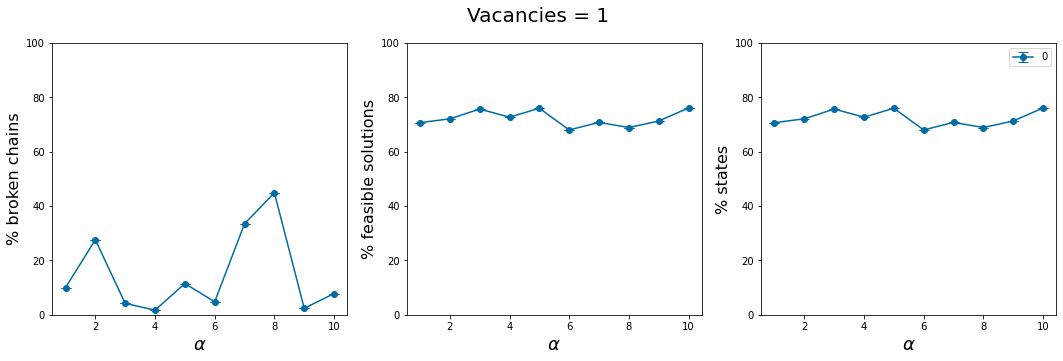

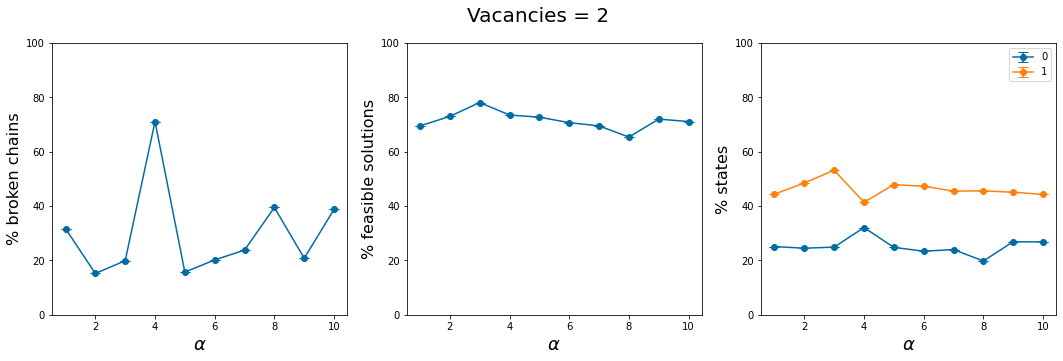

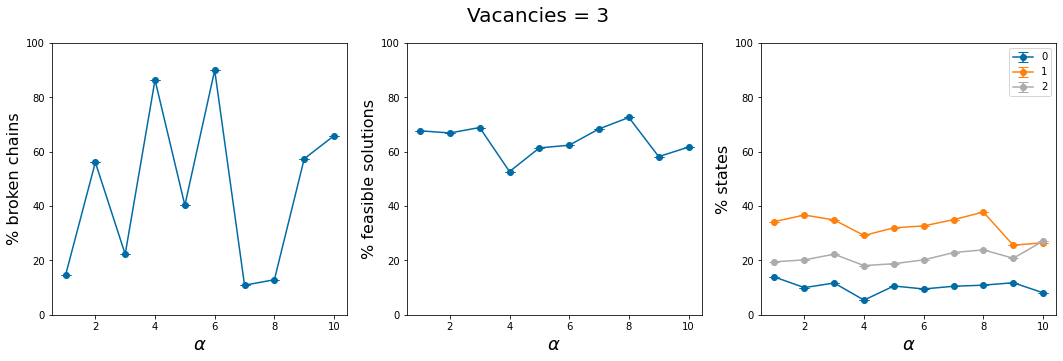

In [21]:
import os
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

directory_main = './data/convergence/absolute_alpha/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = range(1,11)

#to make sure the lowest chain strength return results
#unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]


for i,vac in enumerate([1,2,3]):    
    directory = os.path.join(directory_main,sub_directory[i])
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    
    ratio_broken_chains = []
    ratio_broken_chains_std = []    
    ratio_feasible = []
    ratio_feasible_std = []    
    energy_distribution = []
    energy_distribution_std = []
    
    for ratio in range(1,11):
        ratio_broken_chains_tmp = []
        ratio_feasible_tmp = []
        energy_distribution_tmp = []
        
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json") and '_w1%s_'%ratio in f:
                df, param = load_json(f,return_param = True, return_qubo = False)
                ratio_broken_chains_tmp.append(find_ratio_broken_chains(df)*100)
                ratio_feasible_tmp.append(find_ratio_feasible(df,species=[0,1],concentration=[vac,18-vac])*100)
                energy_distribution_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[1]))
        
        ratio_broken_chains.append(np.average(ratio_broken_chains_tmp))
        ratio_broken_chains_std.append(np.std(ratio_broken_chains_tmp))
        
        ratio_feasible.append(np.average(ratio_feasible_tmp))
        ratio_feasible_std.append(np.std(ratio_feasible_tmp))
        #print(ratio,energy_distribution_tmp)
        energy_distribution_tmp = np.array(energy_distribution_tmp)/num_reads*100       
        energy_distribution.append(np.average(energy_distribution_tmp,axis=0).tolist())
        energy_distribution_std.append(np.std(energy_distribution_tmp,axis=0).tolist())
        
    axs[0].errorbar(x, ratio_broken_chains, yerr = np.array(ratio_broken_chains_std)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, ratio_feasible, yerr = np.array(ratio_feasible_std)/2,fmt='-o',capsize=5)
    labels = [str(x) for x in range(len(energy_distribution[0]))]
    energy_distribution = np.array(energy_distribution)
    energy_distribution_std = np.array(energy_distribution_std)
    for j in range(len(energy_distribution[0])):
        axs[2].errorbar(x, energy_distribution[:,j], yerr = np.array(energy_distribution_std[:,j])/2,
                        label=labels[j], fmt='-o',capsize=5)
    
    axs[0].set_ylabel('% broken chains', fontsize=16)
    axs[1].set_ylabel('% feasible solutions', fontsize=16)
    axs[2].set_ylabel('% states', fontsize=16)
    
    axs[2].legend()
    
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel(r'$\alpha$', fontsize=18)
        axs[i].set_ylim([0, 100])
    plt.show()
    fig.savefig('./data/images/alpha_graphs_%s.png'%str(vac),dpi=200)

# <a id='multiplicity'>Considerations on the configurations multiplicity</a>

## Symmetry of solution

## 1 vacancy

In [22]:
directory = './data/convergence/solution_symmetry/one_vacancy/'

num_reads = 1000
num_runs = len(os.listdir(directory))
dfs = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json"):
        dataframe = load_json(f)[0]
        '''df = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
        display(df)'''
        dfs.append(load_json(f,return_param = False, return_qubo = False))
dataframe = pd.concat(dfs)

df_1v_solsymm = make_df_paper(dataframe,num_vacancies=1,symmetrised=False,only_feasible=True,structure=graphene_supercell)    


sort = np.where(df_1v_solsymm.iloc[:,0:18].to_numpy() == 0)[1]
df_1v_solsymm = df_1v_solsymm.iloc[sort,:]

#Uncomment to save the picture
#dfi.export(df_1v_solsymm,'./data/images/df_1v_solsymm.jpg')

[]

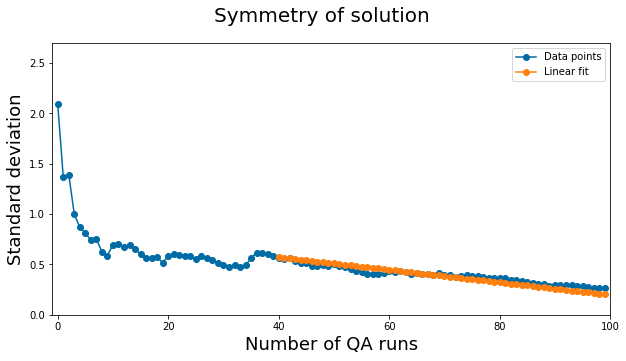

In [23]:
directory = './data/convergence/solution_symmetry/one_vacancy/'

num_reads = 1000
num_runs = len(os.listdir(directory))
dfs = []
std = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json"):
        dataframe = load_json(f)[0]
        dfs.append(load_json(f,return_param = False, return_qubo = False))
    dataframe = pd.concat(dfs)

    df_1v_solsymm = make_df_paper(dataframe,num_vacancies=1,symmetrised=False,only_feasible=True,structure=graphene_supercell)    
    std.append(np.std(df_1v_solsymm['% occurrence']))

fit = np.polyfit(np.arange(0,len(std)), std, 1, rcond=None, full=False, w=None, cov=False)
yy = []
for i in range(40,100):
    yy.append((fit[1]+fit[0]*i))
    
plt.style.use('tableau-colorblind10')
fig, axs = plt.subplots(1,1,figsize=(10, 5), sharey=False)
fig.suptitle('Symmetry of solution', fontsize=20)
axs.plot(np.arange(100),std,'o-',label='Data points')
axs.plot(np.arange(40,100),yy,'o-',label='Linear fit')
axs.set_xlim([-1,100])
axs.set_ylim([0, 2.7])
axs.set_ylabel('Standard deviation', fontsize=18)

axs.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
axs.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
axs.set_xlabel("Number of QA runs", fontsize=18)
axs.legend()

axs.plot()
# Uncomment to save the figure to file
#fig.savefig('./data/images/symmetry_solutions.png',dpi=200)


## 2 vacancies

In [24]:
directory = './data/convergence/solution_symmetry/two_vacancy/'

num_reads = 1000
num_runs = len(os.listdir(directory))
dfs = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json"):
        dataframe = load_json(f)[0]
        '''df = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
        display(df)'''
        dfs.append(load_json(f,return_param = False, return_qubo = False))
dataframe = pd.concat(dfs)

df_2v_solsymm = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,only_feasible=True,structure=graphene_supercell)    

In [25]:
df_2v_solsymm

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1.775,-22.0,36.820887
b,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.915,-21.0,29.100521
c,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1.848,-21.0,9.508691
d,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1.902,-21.0,20.021560
e,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,2.858,-21.0,4.548341


## 3 vacancies

In [26]:
directory = './data/convergence/solution_symmetry/three_vacancy/'

num_reads = 1000
num_runs = len(os.listdir(directory))
dfs = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json"):
        dataframe = load_json(f)[0]
        '''df = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
        display(df)'''
        dfs.append(load_json(f,return_param = False, return_qubo = False))
dataframe = pd.concat(dfs)

df_3v_solsymm = make_df_paper(dataframe,num_vacancies=3,symmetrised=True,only_feasible=True,structure=graphene_supercell)    



# <a id='dft'>Comparing the QA energies to DFT</a>

### single point energy

In [27]:
import os
folder = './data/crystal/scf/'
output_files = []
for file in os.listdir(folder):
    filename = os.fsdecode(file)
    if filename.endswith(".out"):
        output_files.append(filename)
output_files.sort()

scf_energy = []
scf_energy_dict = {}
initial_geom = []

for file in output_files:
    file_name = folder+file
    crystal_output = Crystal_output().read_cry_output(file_name)
    crystal_gui = Crystal_gui().read_cry_gui(file_name[:-3]+'gui')
    scf_energy.append(crystal_output.get_final_energy()/crystal_gui.n_atoms)
    scf_energy_dict[file] = [crystal_output.get_final_energy()/crystal_gui.n_atoms]
    initial_geom.append(cry_gui2pmg(crystal_gui))
    
scf_energy_arr = np.array(scf_energy)
scf_energy_arr[0] = scf_energy_arr[0]-scf_energy_arr[0]
scf_energy_arr[1] = scf_energy_arr[1]-scf_energy_arr[1]
scf_energy_arr[2:7] = (scf_energy_arr[2:7]-scf_energy_arr[2])/16
scf_energy_arr[7:] = (scf_energy_arr[7:]-scf_energy_arr[7])/15

scf_energy_arr_scf = copy.deepcopy(np.round(scf_energy_arr,4))

df_scf = pd.DataFrame.from_dict(scf_energy_dict).transpose()
#df_scf = df_scf.rename(columns={0: 'SCF energy'})
#initial_geom = np.array(initial_geom)

### Geometry optimisation

In [28]:
import os
folder = './data/crystal/optgeom/'
output_files = []
for file in os.listdir(folder):
    filename = os.fsdecode(file)
    if filename.endswith(".out"):
        output_files.append(filename)
output_files.sort()

scf_energy = []
opt_energy = []
final_geom = []
for file in output_files:
    file_name = folder+file
    crystal_output = Crystal_output().read_cry_output(file_name)
    crystal_gui = Crystal_gui().read_cry_gui(file_name[:-3]+'gui')
    scf_energy.append(crystal_output.get_final_energy())
    
    opt_energy.append(crystal_output.get_final_energy()/crystal_gui.n_atoms)
    final_geom.append(cry_gui2pmg(crystal_gui))
    
scf_energy_arr = np.array(opt_energy)
scf_energy_arr[0] = scf_energy_arr[0]-scf_energy_arr[0]
scf_energy_arr[1] = scf_energy_arr[1]-scf_energy_arr[1]
scf_energy_arr[2:7] = (scf_energy_arr[2:7]-scf_energy_arr[2])/16
scf_energy_arr[7:] = (scf_energy_arr[7:]-scf_energy_arr[7])/15

scf_energy_arr_opt = copy.deepcopy(np.round(scf_energy_arr,4))
#df_scf = pd.DataFrame.from_dict(scf_energy_dict).transpose()

#final_geom = np.array(final_geom)


In [29]:
std_disp = []
max_disp = []
for j in range(len(initial_geom)):  
    sum_diff = 0
    all_diff = []
    for i in range(len(final_geom[j].sites)):
        coord_diff = final_geom[j].sites[i].to_unit_cell().coords-initial_geom[j].sites[i].to_unit_cell().coords
        sum_diff += np.sum(coord_diff**2)
        all_diff.append(coord_diff)
    max_disp.append(np.round(np.max(np.array(all_diff)),4))
    std_disp.append(np.round(np.sqrt(sum_diff/final_geom[j].num_sites),4))

In [30]:
df_scf = pd.DataFrame.from_dict(scf_energy_dict).transpose()
df_scf['QA'] = [-27.0, -24.0, -22.0, -21.0, -21.0, -21.0, -21.0,
              -20.0, -19.0, -19.0, -19.0, -19.0, -18.0 , -18.0, -18.0, -18.0, -18.0, -18.0, -18.0, -18.0, -18.0, ]
df_scf['Delta QA'] = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0,
              0.0, 1.0, 1.0, 1.0, 1.0, 2.0 , 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0 ]


df_scf['E sp (eV/atom)'] = np.round(np.array(scf_energy),5)

df_scf['E optgeom (eV/atom)'] = np.round(np.array(opt_energy),5)

df_scf['E sp norm'] = scf_energy_arr_scf
df_scf['Optgeom norm'] = scf_energy_arr_opt
df_scf['Std disp'] = std_disp
df_scf['Max disp'] = max_disp
df_scf.index = ['a','a','a','b','c','d','e','a','b','c','d','e','f','g','h','i','j','k','l','m','n']
df_scf.drop(labels=0,axis=1,inplace=True)
#print(df_scf.to_latex())
df_scf

,QA,Delta QA,E sp (eV/atom),E optgeom (eV/atom),E sp norm,Optgeom norm,Std disp,Max disp
a,-27.0,0.0,-18651.50186,-1036.19455,0.0000,0.0000,0.0000,0.0000
a,-24.0,0.0,-17607.33385,-1035.72552,0.0000,0.0000,0.0257,0.0532
a,-22.0,0.0,-16570.07913,-1035.62995,0.0000,0.0000,0.0940,0.1201
b,-21.0,1.0,-16563.03815,-1035.18988,0.0272,0.0275,0.0392,0.0724
c,-21.0,1.0,-16563.80158,-1035.23760,0.0218,0.0245,0.1784,0.5633
d,-21.0,1.0,-16566.39801,-1035.39988,0.0171,0.0144,0.0734,0.1301
e,-21.0,1.0,-16566.02096,-1035.37631,0.0175,0.0159,0.0687,0.1247
a,-20.0,0.0,-15530.61656,-1035.37444,0.0000,0.0000,0.0492,0.1065
b,-19.0,1.0,-15523.33897,-1034.88926,0.0182,0.0323,0.1525,0.2776
c,-19.0,1.0,-15528.99439,-1035.26629,0.0166,0.0072,0.2092,0.2144
